## Esercitazione: Machine Translation

Costruire un modello sequenziale per la traduzione (dall'inglese all'italiano). Il modello prende una sequenza in inglese e torna in output una sequenza in italiano:
1. Costruire le sequenze ed effettuare il padding per entrambe le lingue (NB: le sequenze vanno paddate alla maxlen di entrambe le lingue)
2. Dividi il dataset tra train e test con il 20% di test_size
2. Definire un modello che abbia uno strato di embedding e almeno due strati ricorrenti e in uscita uno strato Dense con il numero di neuroni pari al vocabolario per la traduzione (italiano)
3. NB: Per migliorare le performance sullo strato Dense conviene applicare un layer TimeDistributed in questo modo
        TimeDistributed(Dense())
3. Eseguire l'addestramento per almeno 100 epoche

In [1]:
#Say no to warnings
# import warnings
# warnings.filterwarnings("ignore")
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# import tensorflow as tf
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("machine_translation.csv")

In [3]:
df

,italian,english
0,tom portò i suoi.,tom brought his.
1,a te non piace il pesce?,don't you like fish?
2,non abbiamo mai riso.,we never laughed.
3,aspetti un momento.,hang on a moment.
4,quando è finito?,when did that end?
...,...,...
49995,non la riesco a salvare.,i can't save you.
49996,lui è scomparso.,he disappeared.
49997,ha più di trent'anni.,he's over thirty.
49998,il cane sta ansimando.,the dog is panting.


### Preprocessing
The preprocessing step here is the definition of Tokenizer, and vocabulary, for both languages. Last processing step is a padding, such that all sequences have same lenght.

First extract italian and english texts from dataframe

In [4]:
italian_texts = df["italian"].values
italian_texts.shape

(50000,)

In [5]:
english_texts = df["english"].values
english_texts.shape

(50000,)

### Train test split
Here there isn't a classic feature matrix and a label array (i.e. X and y), but there are two sets of sequences, where input (X equivalent) are the english texts, and desired output (y equivalent) are the italian texts. I have to do train_test_split on these variables.

In [6]:
from sklearn.model_selection import train_test_split

texts_eng_train, texts_eng_test,\
texts_ita_train, texts_ita_test =\
train_test_split(english_texts, italian_texts, test_size=.2,
                 random_state=42)

#check
print(texts_eng_train.shape)
print(texts_eng_test.shape)
print(texts_ita_train.shape)
print(texts_ita_test.shape)

(40000,)
(10000,)
(40000,)
(10000,)


Tokenizers must be fitted on train set

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 10000
tokenizer_ita = Tokenizer()
tokenizer_ita.fit_on_texts(texts_ita_train)

sequences_ita_train = tokenizer_ita.texts_to_sequences(texts_ita_train)
sequences_ita_test = tokenizer_ita.texts_to_sequences(texts_ita_test)


max_len_ita = len(max(sequences_ita_train,key=len))
sequences_ita_train = pad_sequences(sequences_ita_train,padding='pre',
                                   maxlen=max_len_ita)
sequences_ita_test = pad_sequences(sequences_ita_test,padding='pre',
                                   maxlen=max_len_ita)
print(sequences_ita_train.shape)

vocabulary_ita_len = len(tokenizer_ita.word_index)
print(vocabulary_ita_len)

(40000, 10)
9995


In [8]:
tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(texts_eng_train)

sequences_eng_train = tokenizer_eng.texts_to_sequences(texts_eng_train)
sequences_eng_test = tokenizer_eng.texts_to_sequences(texts_eng_test)


max_len_eng = len(max(sequences_eng_train,key=len))

sequences_eng_train = pad_sequences(sequences_eng_train,padding='pre',
                              maxlen=max_len_eng)
sequences_eng_test = pad_sequences(sequences_eng_test,padding='pre',
                              maxlen=max_len_eng)
print(sequences_eng_train.shape)

vocabulary_eng_len = len(tokenizer_eng.word_index)
print(vocabulary_eng_len)

(40000, 6)
4942


It's suggested to pad both languages sequences to same lenght, using the maximum between the two maxlen.

In [9]:
max_len_ita, max_len_eng

(10, 6)

In [10]:
sequences_eng_train = pad_sequences(sequences_eng_train,padding='pre',
                              maxlen=max_len_ita)
sequences_eng_test = pad_sequences(sequences_eng_test,padding='pre',
                              maxlen=max_len_ita)

print(sequences_eng_train.shape)
print(sequences_eng_test.shape)

(40000, 10)
(10000, 10)


### Model
The model is a Sequential model, using RNN layers

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense,\
SimpleRNN, InputLayer, TimeDistributed
from tensorflow.keras.backend import clear_session

clear_session()

model = Sequential()
model.add(InputLayer(shape=(max_len_ita,)))
model.add(Embedding(vocabulary_eng_len+1, 100))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True))
model.add(TimeDistributed(\
                          Dense(vocabulary_ita_len+1,
                                activation='softmax')))
# model.add(Dense(vocabulary_ita_len+1,activation='softmax'))
#vocabulary_ita_len+1 is for padding

#Loss = ???? metrics = ?????
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
             optimizer='rmsprop')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 10, 100)        │       494,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 10, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 9996)       │       649,740 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185,704 (4.52 MB)

 Trainable params: 1,185,704 (4.52 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from tensorflow.keras.callbacks import Callback
class MyCallback(Callback):
    def __init__(self):
        print()
    def on_epoch_end(self,epoch,logs):
        self.model.stop_training = logs["val_accuracy"] >= 0.7
        if(logs["val_accuracy"] >= 0.7):
            print(f"Early stopping at epoch {epoch}")

In [13]:
cb = MyCallback()

In [14]:
# %%time
history = model.fit(sequences_eng_train,
                    sequences_ita_train,
                    epochs=10,
                    batch_size=200,
                    validation_split=0.2,
                    callbacks=[cb],
                    verbose=1)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 289ms/step - accuracy: 0.6275 - loss: 6.2100 - val_accuracy: 0.6537 - val_loss: 2.9560
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 47s 292ms/step - accuracy: 0.6519 - loss: 2.7315 - val_accuracy: 0.6539 - val_loss: 2.4244
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 46s 290ms/step - accuracy: 0.6551 - loss: 2.3727 - val_accuracy: 0.6659 - val_loss: 2.3078
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 47s 291ms/step - accuracy: 0.6646 - loss: 2.2839 - val_accuracy: 0.6692 - val_loss: 2.2511
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 46s 290ms/step - accuracy: 0.6672 - loss: 2.2314 - val_accuracy: 0.6775 - val_loss: 2.2046
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 49s 305ms/step - accuracy: 0.6775 - loss: 2.1786 - val_accuracy: 0.6851 - val_loss: 2.1633
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 47s 292ms/step - accuracy: 0.6845 - loss: 2.1290 - val_accuracy: 0.6889 - val_loss: 2.1233
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 47s 293ms/step - accuracy: 0.6877 - loss: 2

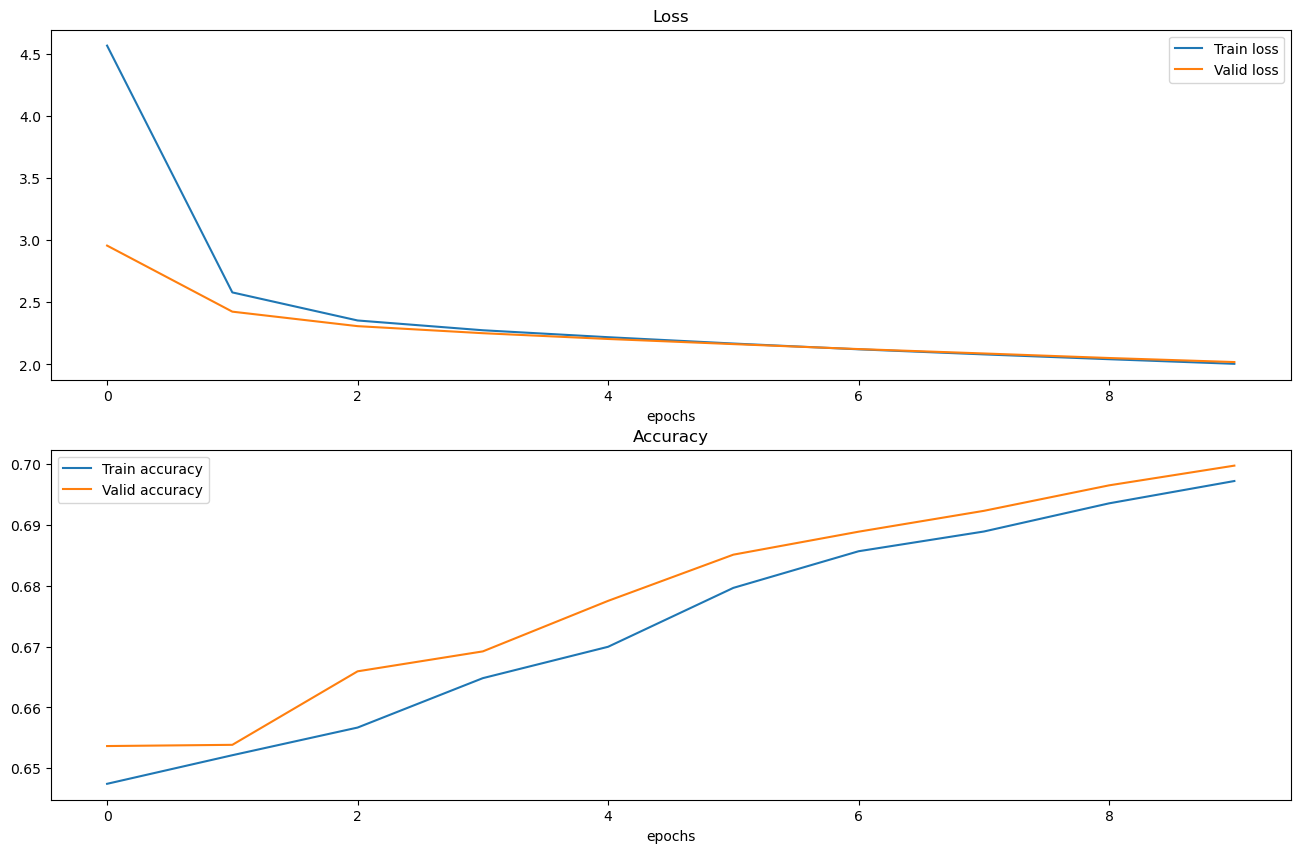

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot(history.history["loss"],label="Train loss")
plt.plot(history.history["val_loss"],label="Valid loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"],label="Train accuracy")
plt.plot(history.history["val_accuracy"],label="Valid accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.show()


In [16]:
predictions = model.predict(sequences_eng_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


In [17]:
predictions.shape

(10000, 10, 9996)

In [18]:
help(tokenizer_ita.index_word)

Help on dict object:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Built-in subclasses:
 |      StgDict
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if the dictionary has the specified key, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>va

In [19]:
tokenizer_ita.index_word

{1: 'tom',
 2: 'è',
 3: 'non',
 4: 'io',
 5: 'sono',
 6: 'a',
 7: 'la',
 8: 'di',
 9: 'un',
 10: 'mi',
 11: 'il',
 12: 'ho',
 13: 'ha',
 14: 'una',
 15: 'lei',
 16: 'noi',
 17: 'sei',
 18: 'lo',
 19: 'siamo',
 20: 'siete',
 21: 'che',
 22: 'voi',
 23: 'era',
 24: 'tu',
 25: 'in',
 26: 'lui',
 27: 'si',
 28: 'questo',
 29: 'per',
 30: 'le',
 31: 'molto',
 32: 'me',
 33: 'piace',
 34: 'loro',
 35: 'posso',
 36: 'qui',
 37: 'i',
 38: 'così',
 39: 'ci',
 40: 'ero',
 41: 'sta',
 42: 'mio',
 43: 'casa',
 44: 'con',
 45: 'ora',
 46: 'ti',
 47: 'adesso',
 48: 'voglio',
 49: 'bisogno',
 50: 'abbiamo',
 51: 'vi',
 52: 'chi',
 53: 'sto',
 54: 'mia',
 55: 'sembra',
 56: 'da',
 57: 'come',
 58: 'andare',
 59: 'tutti',
 60: 'cosa',
 61: 'questa',
 62: 'ne',
 63: 'fatto',
 64: 'ancora',
 65: 'bene',
 66: 'troppo',
 67: 'essere',
 68: 'del',
 69: 'perché',
 70: 'può',
 71: 'mai',
 72: 'avete',
 73: 'devo',
 74: 'hai',
 75: 'suo',
 76: 'stato',
 77: 'amo',
 78: 'odio',
 79: 'più',
 80: "po'",
 81: "l'h

In [20]:
def pred_to_text(prediction, tokenizer):
    index_to_words = tokenizer.index_word.copy()
    index_to_words[0] = "<PAD>"
#     print(index_to_words)
    return ' '.join(index_to_words[pred] for pred in np.argmax(prediction,1))

In [21]:
idx = 25
print(pred_to_text(predictions[idx],tokenizer_ita))
print("="*10)
print(texts_ita_test[idx])

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> siamo così andare
stiamo solamente parlando.


It's a total mess :) 

This is happening, because here we're using a RNN vanilla, where there is the problem of vanishing gradient. 

Recollect that sequences have length 10 and it means that first items are penalized (i.e. fist states, like h_1, h_2 are subjected to vanishing gradient). For this reason it's more suitable to do a pre padding (instead of post padding, like in first run)

In [22]:
np.argmax(predictions,2).shape

(10000, 10)

Alternative way to compute text from sequences.

NB: sequences are computed with:

`np.argmax(predictions,2)`



In [23]:
texts_pred = tokenizer_ita.sequences_to_texts(np.argmax(predictions,2))

print(texts_pred[idx])

siamo così andare
